# Sampling Problem

Understanding a program's resilence characterisitc usually need to a lot of fault injection experiments to test the program's multiple region. However, the potential fault injection location are tremendous which is almost impossible test all of them. A reasonable sampling strategy, which get a small fraction of the data but get better understanding,  are necessary to develop. 

Previous experiment teach us, low mantissa bit have less impact compare to high mantissa bit and exponent bit. In this study, we propose a sampling strategy which extract small fraction of the sample from low mantissa bit and large fraction from the high mantissa and exponent bit. 

Our experiment shows that our sampling strategy have similar result with the grand truth. Compare to the random sampling, our method have low standard deviation.


1. what is the edge between high bit and low bit. 24/64
2. what's the percentage come from low bit, what's the percentage come from high bit


In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
dataset = []
highbit_dataset = []
allline = set()

with open('cg_complete.csv') as f:
    lines = f.readlines()

attributes = lines.pop(0)    
outcomeindex = attributes.strip('\n\t ').split(',').index('outcome')
 

for line in lines:
    line = line.strip('\r\n').split(',')
    allline.add(line[2])
    dataset.append(line)

for d in dataset:
    if float(d[-1]) > 40:
        highbit_dataset.append(d)

#calculate the sdc ratio base on the given data set
def calculate_SDC_ratio(data, ratio = 1.0):
    dataset = {'Masked':0.0, 'SDC':0.0, 'DUE':0.0}
    for d in data:
        dataset[d[outcomeindex]] += 1 
    return dataset['SDC']/(dataset['SDC'] + dataset['Masked'] + dataset['DUE']) * ratio
    
def calculate_SDC_Impact(data):
    result = {}
    for d in data:
        if d[outcomeindex-1] != 'nan':
            if d[2] in result:
                result[d[2]].append(float(d[outcomeindex-1]))
            else:
                result[d[2]] = [float(d[outcomeindex-1])]
    
    for key in result:
        result[key] = np.log(np.mean(result[key]))
    
    return result

def calculate_SDC_ratio_local(data, ratio=1.0):
    lines = {}
    result = {}
    
    for d in data:
        if d[2] in lines:
            lines[d[2]][d[outcomeindex]] += 1
        else:
            lines[d[2]] = {'Masked':0.0, 'SDC':0.0, 'DUE':0.0}
    
    for key, value in lines.iteritems():
        count = lines[key]['Masked'] + lines[key]['SDC'] + lines[key]['DUE']
        if count == 0:
            result[key] = 0
        else:
            result[key] = lines[key]['SDC']/ count * ratio
        
    return result

def sampling(data, sample_size =1000):
    sample = []
    data_size = len(data)
    
    for i in range(sample_size):
        index = np.random.randint(data_size)
        sample.append(data[index])
    return sample

def sampling_high_bit(data, sample_size = 1000):
    sample = []
    data_size = len(data)
    
    for i in range(sample_size):
        index = np.random.randint(data_size)
        sample.append(data[index])
    return sample


sdc_global_exhaust = []
sdc_global_highbit = []

sdc_local_exhaust = {}
sdc_local_highbit = {}

sdc_impact_exhaust = {}
sdc_impact_highbit = {}

for line in allline:
    sdc_local_exhaust[line] = []
    sdc_local_highbit[line] = []
    sdc_impact_exhaust[line] = []
    sdc_impact_highbit[line] = []

for i in range(1000):
    sample_exhaust = sampling(dataset)
    sample_highbit = sampling(highbit_dataset)
    
    sdc_global_exhaust.append(calculate_SDC_ratio(sample_exhaust))
    sdc_global_highbit.append(calculate_SDC_ratio(sample_highbit, 24.0/64))
    
    #sdc local
    exhaust_item = calculate_SDC_ratio_local(sample_exhaust)
    highbit_item = calculate_SDC_ratio_local(sample_highbit, 24.0/64)
    
    for key in exhaust_item:
        sdc_local_exhaust[key].append(exhaust_item[key])
    for key in highbit_item:
        sdc_local_highbit[key].append(highbit_item[key])
    
    #sdc impact local
    exhaust_item = calculate_SDC_Impact(sample_exhaust)
    highbit_item = calculate_SDC_Impact(sample_highbit)

    for key in exhaust_item:
        sdc_impact_exhaust[key].append(exhaust_item[key])
    for key in highbit_item:
        sdc_impact_highbit[key].append(highbit_item[key])

print "Done"
#sample = sampling(dataset)
#print calculate_SDC_ratio(dataset)
#print calculate_SDC_ratio(sample)
#print calculate_SDC_Impact(sample)
#print calculate_SDC_ratio_local(sample)

Done


## Global SDC Ratio

In [39]:
print np.mean(sdc_global_exhaust)
print np.std(sdc_global_exhaust)

print np.mean(sdc_global_highbit)
print np.std(sdc_global_highbit)

0.083386
0.009033105999599472
0.083636625
0.004749875575673009


# SDC local ratio

167    0.034211
175    0.101413
25     0.012407
33     0.051609
40     0.014992
48     0.040201
57     0.045064
75     0.236062
76     0.075978
82     0.070900
83     0.155085
84     0.067093
87     0.042985
90     0.165317
91     0.163822
dtype: float64
167    0.018629
175    0.055799
25     0.006697
33     0.028524
40     0.009034
48     0.021820
57     0.024286
75     0.133045
76     0.038307
82     0.042175
83     0.083126
84     0.045707
87     0.028568
90     0.082022
91     0.081727
dtype: float64


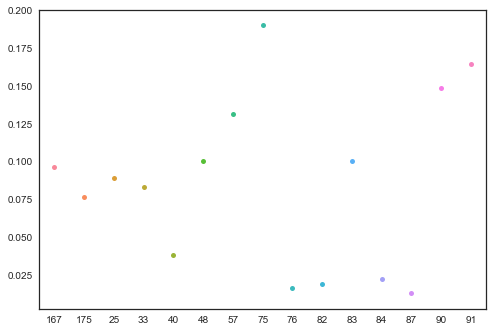

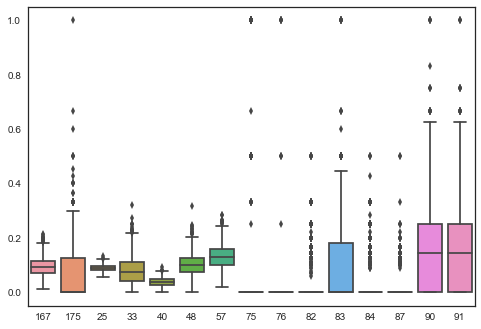

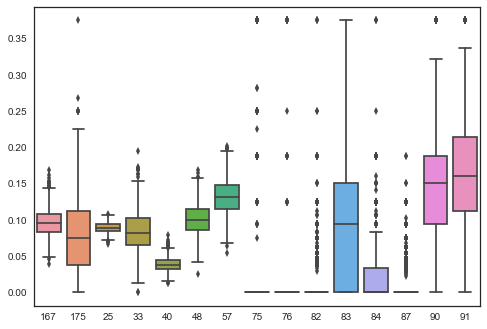

In [40]:
for key in sdc_local_exhaust:
    while len(sdc_local_exhaust[key]) < 1000:
        sdc_local_exhaust[key].append(0)
    while len(sdc_local_highbit[key]) < 1000:
        sdc_local_highbit[key].append(0)

exhaust = pd.DataFrame.from_dict(sdc_local_exhaust)
highbit = pd.DataFrame.from_dict(sdc_local_highbit)

grandtruth = calculate_SDC_ratio_local(dataset)
name = []
values = []

for key in sorted(grandtruth.iterkeys()):
    name.append(key)
    values.append(grandtruth[key])

print exhaust.std()
print highbit.std()
sns.set(style='white')
plt.close()
#plt.subplot(3, 1, 1)
sns.stripplot(name, values)
#plt.subplot(3, 1, 2)
plt.figure()
sns.boxplot(data=exhaust)
#plt.subplot(3, 1, 3)
plt.figure()
sns.boxplot(data=highbit)
#print sdc_local.keys()
#print sdc
#sns.boxplot(sdc_local.keys(), sdc_local.values())
plt.show()


# SDC Impact

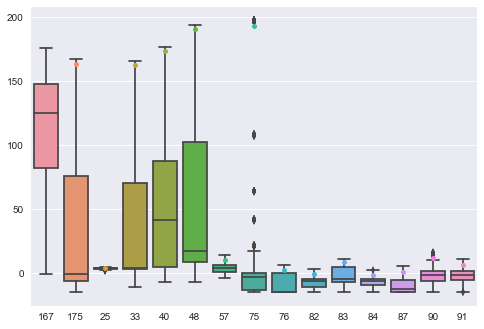

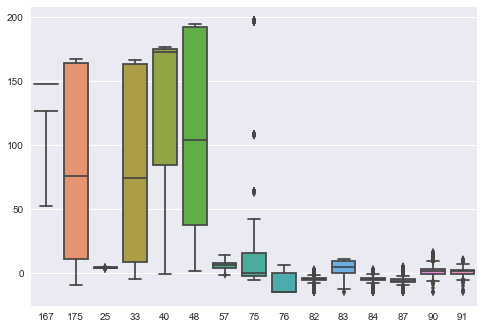

In [8]:
#print sdc_impact

for key in sdc_impact_exhaust:
    while len(sdc_impact_exhaust[key]) < 1000:
        sdc_impact_exhaust[key].append(0)
    while len(sdc_impact_highbit[key]) < 1000:
        sdc_impact_highbit[key].append(0)
        
exhaust = pd.DataFrame.from_dict(sdc_impact_exhaust)
highbit = pd.DataFrame.from_dict(sdc_impact_highbit)

grandtruth = calculate_SDC_Impact(dataset)
name = []
values = []
for k in sorted(grandtruth.iterkeys()):
    name.append(k)
    values.append(grandtruth[k])
sns.stripplot(name, values)

#plt.figure()
#dataframe = pd.DataFrame.from_dict(sdc_impact)
#plt.figure()
sns.boxplot(data=exhaust)
#plt.subplot(3, 1, 3)
plt.figure()
sns.boxplot(data=highbit)
plt.show()
